# CNN for AED with Keras/TensorFlow

Date: November 11, 2018

Neural network: three convolution layers and three fully connected layers

Classification of acoustic events:

- Piano music
- Framenco guitar music
- Classical guitar music
- Blues hars music
- Tin whistle music
- Silence

## Preparing data set for CNN

In [2]:
DATASET_FOLDER = '../dataset/data_music'

%run dataset.py

ds = DataSet(DATASET_FOLDER)
train_data, train_labels, test_data, test_labels = ds.generate()
shape = ds.get_shape()
class_labels = ds.get_class_labels()

### CNN model

In [3]:
from keras import layers
from keras import models

model = models.Sequential()

model.add(layers.Conv2D(4, (3, 3), activation='relu', input_shape=(*shape, 1)))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(8, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(class_labels), activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 38, 4)         40        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 19, 4)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 17, 8)         296       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 8, 8)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 6, 16)         1168      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 3, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 288)               0         
__________

In [4]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

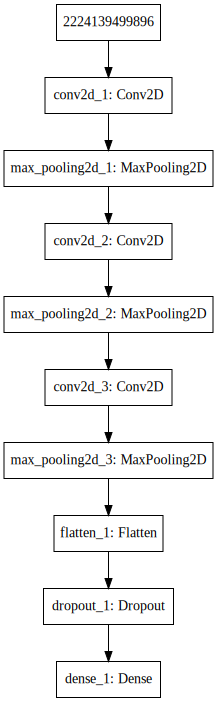

In [5]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

## Training CNN

In [6]:
EPOCHS = 30
history = model.fit(train_data, train_labels, epochs=EPOCHS, validation_data=(test_data, test_labels))

Train on 1206 samples, validate on 594 samples
Epoch 1/30
1206/1206 [==============================] - 9s 8ms/step - loss: 1.6103 - acc: 0.3358 - val_loss: 1.1959 - val_acc: 0.6616
Epoch 2/30
1206/1206 [==============================] - 8s 6ms/step - loss: 1.0719 - acc: 0.5987 - val_loss: 0.8136 - val_acc: 0.7256
Epoch 3/30
1206/1206 [==============================] - 8s 7ms/step - loss: 0.8906 - acc: 0.6443 - val_loss: 0.6832 - val_acc: 0.7593
Epoch 4/30
1206/1206 [==============================] - 8s 7ms/step - loss: 0.7715 - acc: 0.6808 - val_loss: 0.6199 - val_acc: 0.7593
Epoch 5/30
1206/1206 [==============================] - 8s 7ms/step - loss: 0.6900 - acc: 0.7264 - val_loss: 0.5490 - val_acc: 0.7946
Epoch 6/30
1206/1206 [==============================] - 8s 7ms/step - loss: 0.5909 - acc: 0.7720 - val_loss: 0.5120 - val_acc: 0.8098
Epoch 7/30
1206/1206 [==============================] - 8s 7ms/step - loss: 0.5771 - acc: 0.7620 - val_loss: 0.4772 - val_acc: 0.8047
Epoch 8/30
1206

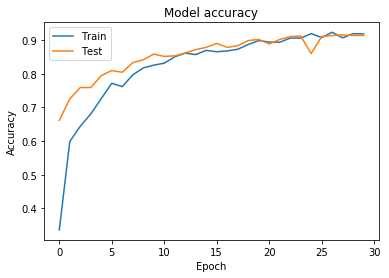

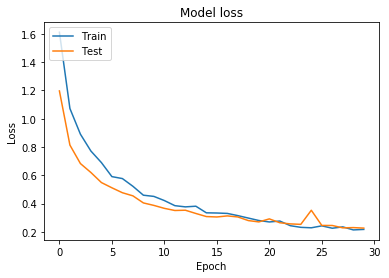

In [7]:
%run history.py
%matplotlib inline

plot_accuracy(history)
plot_loss(history)

## Save the model

In [8]:
import datetime

dt = datetime.datetime.today().strftime('%Y%m%d%H%M%S')
filename = DATASET_FOLDER + '/cnn_for_aed_{}.h5'.format(dt)
model.save(filename)

## Load the model

In [9]:
del model
model = models.load_model(filename)

## Confirmation

In [10]:
import numpy as np
import matplotlib.pyplot as plt
train_data.shape

(1206, 64, 40, 1)

In [11]:
layer_outputs = [layer.output for layer in model.layers]
#layer_outputs

In [12]:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(test_data)
#activations[0][0,:,:,0].shape

In [13]:
class_labels

['blues_harp',
 'classical_guitar',
 'framenco_guitar',
 'piano',
 'silence',
 'tin_whistle']

In [14]:
(activations[-1][:10]*100).astype(int)

array([[  0,   2,   0,  97,   0,   0],
       [  0,   0,   0,   0,   0,  99],
       [  0,  88,   0,  11,   0,   0],
       [  0,   0,  99,   0,   0,   0],
       [  0,  76,  23,   0,   0,   0],
       [ 99,   0,   0,   0,   0,   0],
       [ 99,   0,   0,   0,   0,   0],
       [  0,  84,  10,   4,   0,   0],
       [  0,   0,   0,   0,   0, 100],
       [  0,   0,   0,   0,   0,  99]])

In [15]:
test_labels[:10].astype(int)

array([[0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1]])

In [16]:
def plot_layer(activations, sample, layer):
    a = activations[layer].shape
    rows = int(a[3]/4)
    fig, axarr = plt.subplots(rows, 4, figsize=[20,15])
    for i in range(a[3]):
        row = int(i/4)
        x, y = row, i-4*row
        axarr[x, y].imshow(np.rot90(activations[layer][sample, :, :, i]))
        axarr[x, y].set_xticks([])
        axarr[x, y].set_yticks([])

'blues_harp'

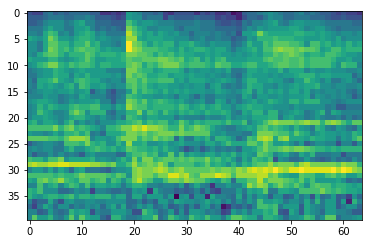

In [17]:
image_number = 25

plt.imshow(np.rot90(test_data[image_number,:,:,0]))
class_labels[np.argmax(test_labels[image_number])]

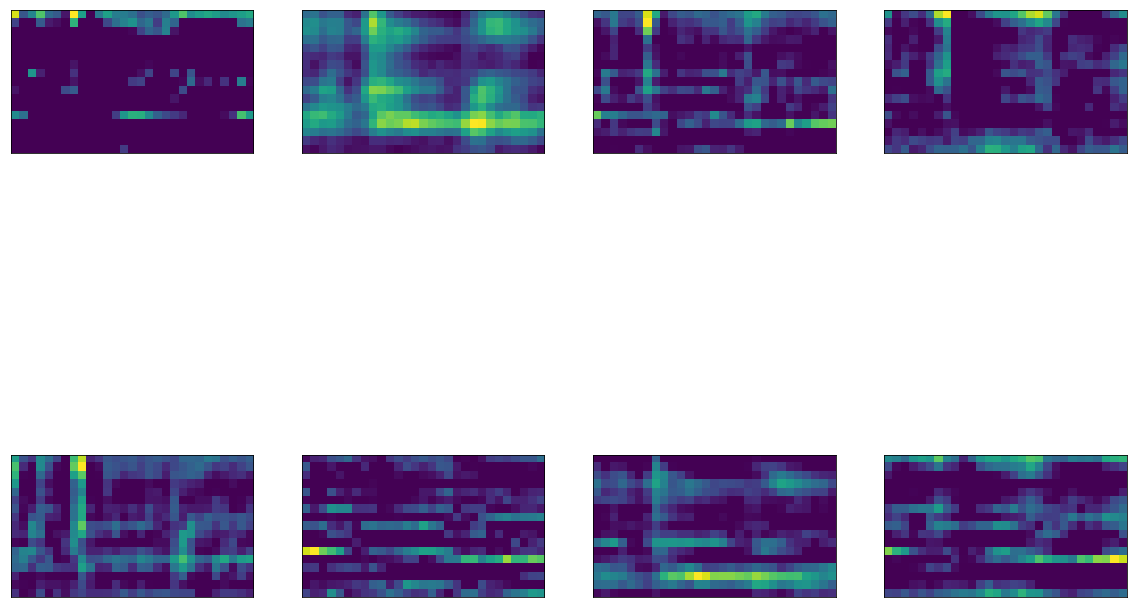

In [18]:
plot_layer(activations, image_number, 2)

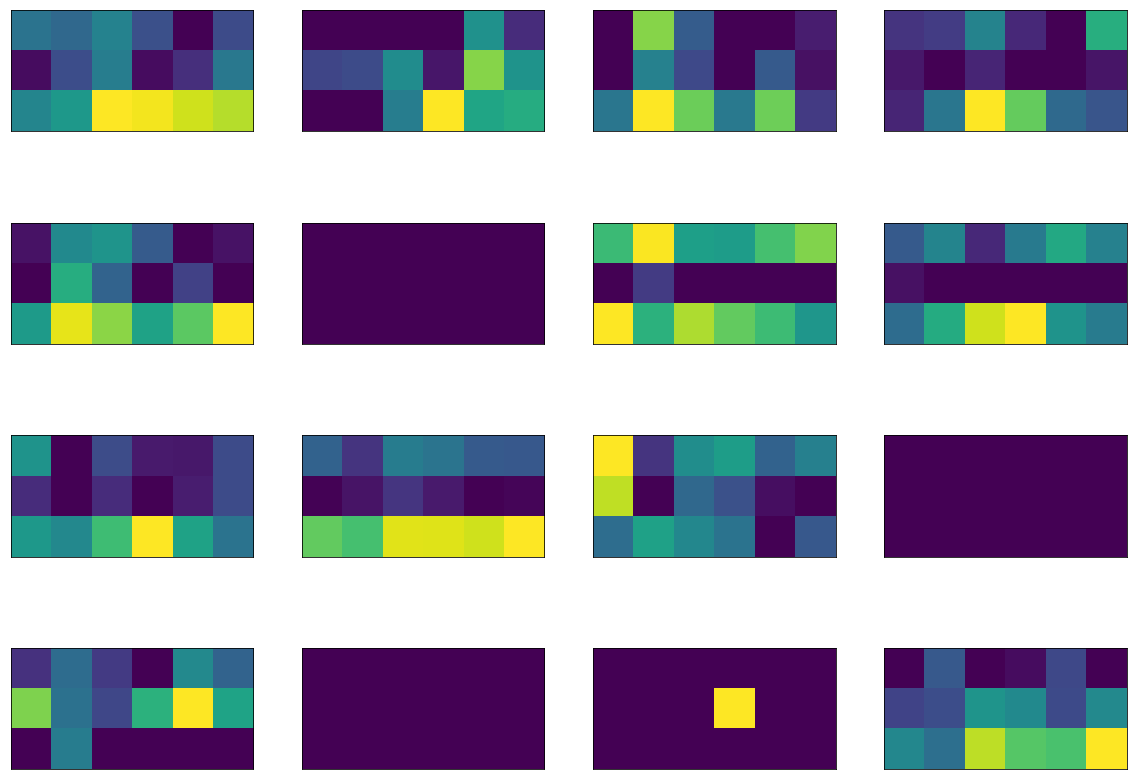

In [19]:
plot_layer(activations, image_number, 5)